# Applied Data Science: Correlation coefficients 

Author: Anna Herrmann \
Date: 26.10.2021

Last changed: 09.11.2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.graphics.api as smg
from patsy import dmatrices

import warnings
warnings.filterwarnings("ignore")

#%matplotlib qt
%matplotlib inline

from matplotlib import rc
rc('font', **{'family':'sans-serif', 'sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{lmodern}"]
params = {'text.usetex': True,
         'font.size': 11,
         'font.family': 'lmodern'}
plt.rcParams.update(params)

In [2]:
# import data from Oxford index
Data_index = pd.read_csv(r'./DATA_Countries/OxCGRT_latest.csv')

# parse dates to make them useable
Data_index['Date'] = pd.to_datetime(Data_index['Date'], format='%Y%m%d')

# calculate mortality
Data_index['Mortality'] = Data_index['ConfirmedDeaths']/Data_index['ConfirmedCases']

# drop Data seperated for States on national level
# drop rows that contain STATE_TOTAL in Jurisdiction
Data_index = Data_index[~Data_index.Jurisdiction.str.contains('STATE_TOTAL')]

# drop all columns not necessary for future analysis
Data_index = Data_index.drop(['RegionName', 'RegionCode', 'Jurisdiction', 'C1_Flag', 'C2_Flag', 
                              'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag',
                              'H1_Flag', 'H6_Flag', 'H7_Flag', 'H8_Flag', 'M1_Wildcard',
                              'StringencyIndexForDisplay', 'StringencyLegacyIndex',
                              'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndexForDisplay',
                              'ContainmentHealthIndexForDisplay', 'EconomicSupportIndexForDisplay'], axis=1)

# check table head 
Data_index.head()

,CountryName,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,...,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Mortality
0,Aruba,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
1,Aruba,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
2,Aruba,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
3,Aruba,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
4,Aruba,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN


### Functionality of function oneCountry_analysis():
- function takes in country
- extracts data for that country from OxCGRT_latest.csv
- shift the data on mortality if wanted
- find minimum and maximum in stringency in the beginning of the pandemic
- create time frames for after the extremes
- linear regression of mortality over stringency in these time frames
- compute correlation of mortality and stringency in these time frames

In [3]:
def oneCountry_analysis(CountryName=0, CountryCode=0, days_0=30, days_x=30, temp_days=10, 
                        mortality_shift=False, method='spearman', print_notes=False, plot_figures=False,
                        corr_matrix=False):
    
    # INPUTS:
    # CountryName (string):   name of the country which is to be analysed, needs to be found in table
    # CountryCode (string):   alternative to name 
    # days_0 (int):           number of days after first policy implementation that should be compared
    # days_x (int):           number of days after first easing of policies that should be compared 
    # temp_days (int):        number of days that index needs to fall -> not working as of now (29.10.21)
    # mortality_shift (bool): if true, the mortality data is shifted by 21 days
    # method (string):        'spearman' or 'pearson' --> determines the method for calculation of correlation coefficient
    # print_notes (bool):     if true, then some for correlation are printed in the console
    # plot_figures (bool):    if true, then mortality-stringency plot over all time and limited to the time frames are 
    #                         plotted, as well as linear regression in the time frames
    # corr_matrix (bool):     (recommend = False), if true correlation matrix for all variables in table is created for 
    #                         time frame after the maximum in stringency 
    
    # OUTPUTS:
    # 
    
    ### ----------------------------------------------------------------------------------------
    ### BEGIN: READING DATA
    ### ----------------------------------------------------------------------------------------
    
    if CountryCode != 0:
        # read Data using CountryCode --> get country name
        # this borderline unnecessary
        if ((Data_index.CountryCode==CountryCode).any()) == False:
            print("Country Code does not exist.")
            return -1
        
        Data_country = Data_index.loc[Data_index['CountryCode'] == CountryCode]
        
    elif CountryName != 0:
        # read Data using Name of Country
        if ((Data_index.CountryName==CountryName).any()) == False:
            print("Country Name does not exist.")
            return -1
        
        Data_country = Data_index.loc[Data_index['CountryName'] == CountryName]
        
    elif CountryCode == 0 and CountryName == 0:
        print("Task failed succesfully! - Need a country to look at.")
        return -1
    
    
    # reset index to avoid potential issues with big number, idk
    Data_country = Data_country.reset_index(drop=True)
    
    # define length of DataFrame
    Data_len = len(Data_country.index.values)
    Data_col = len(Data_country.columns.values)
    
    ### ----------------------------------------------------------------------------------------
    ### END: READING DATA
    ### ----------------------------------------------------------------------------------------
    ###
    ###
    ###
    ### ----------------------------------------------------------------------------------------
    ### BEGIN: SHIFT MORTALITY DATA
    ### ----------------------------------------------------------------------------------------
    
    # GOAL: Shift mortality data by 21 days to account for delay 
    
    if mortality_shift == True:
        # create 0s to add to end of table
        add_days = pd.DataFrame(np.empty((21, Data_col)), columns = Data_country.columns)
        
        # add empty data to end of DataFrame
        temp_Data_country = pd.concat([Data_country, add_days], ignore_index=True)
        
        # reset index for temporary DataFrame
        temp_Data_country = temp_Data_country.reset_index(drop=True)
        
        temp_Data_country['shifted_Mortality'] = np.empty((Data_len+21,1))*np.nan
        
        for i in np.arange(0,Data_len,1):
            temp_Data_country.shifted_Mortality[i+21]=temp_Data_country.Mortality[i]
            
        temp_Data_country.drop(temp_Data_country.index[(Data_len):(Data_len+21)], inplace=True)
        
        # Overwrite Mortality column
        temp_Data_country.Mortality = temp_Data_country.shifted_Mortality
        
        # drop shifted Mortality column
        temp_Data_country.drop(['shifted_Mortality'], axis=1, inplace=True)
        
        # overwrite Data_country with temp file
        Data_country = temp_Data_country
    
    ### ----------------------------------------------------------------------------------------
    ### END: SHIFT MORTALITY DATA
    ### ----------------------------------------------------------------------------------------
    ###
    ###
    ###
    ### ----------------------------------------------------------------------------------------
    ### BEGIN: DETERMINING TIME FRAMES
    ### ----------------------------------------------------------------------------------------
    
    # identify the maxima / minima for the country
    day_0 = [] # array for days, when measures were increased (and the following days)
    day_x = [] # array for days, when restrictions were eased (over a long period of time ~30d?)

    # First implementation
    for index, row in Data_country.iterrows():
        if row['StringencyIndex'] != 0:
            day_0.append(index)
            break
    
    # First lift
    for index, row in Data_country.iterrows():
        if index == 0:
            temp = row['StringencyIndex']
            continue
            
        if temp > row['StringencyIndex']:
            day_x.append(index)
            break
            
        temp = row['StringencyIndex']
    
    if day_0 == [] or day_x == []:
        print('Something went wrong! (: - No days could be found. ')
        return -1
    
    # Subsequent Maxima and Lifts 
    # NOT WORKING (as of 09.11.2021)
    for index, row in Data_country.iterrows():
        
        # start from first day_x
        # skip all days til that first day
        if index < day_x[0]:
            continue
        
        # define StringencyIndex for comparison
        if index == day_x[0]:
            temp = row['StringencyIndex']
            continue
        
        # find day, where measures were increased, over a longer period of time
        
        if temp <= row['StringencyIndex']:
            # check if for temp_days the relation is true
            check_days = index + np.arange(1, temp_days+1, 1)
            # get array with value for that time frame
            Data_check = Data_country[index:(index+temp_days)]['StringencyIndex']
            
            # Flag to indicate if condition stays true
            check_days_condition = True # False == index increases over time frame, True == index keeps decreasing over time frame
            
            for i in Data_check:
                if i >= temp:
                    check_days_condition = False
                    break
            
            if check_days_condition == False:
                temp = row['StringencyIndex'] 
                continue
            
            if check_days_condition == True:
                day_0.append(index)
    
        # reset stringency value to value of current day
        temp = row['StringencyIndex'] 
        
    ### ----------------------------------------------------------------------------------------
    ### END: DETERMINING TIME FRAMES
    ### ----------------------------------------------------------------------------------------
    ###
    ###
    ###
    ### ----------------------------------------------------------------------------------------
    ### BEGIN: LINEAR REGRESSION IN TIME FRAMES
    ### ----------------------------------------------------------------------------------------
    
    # Determine correlation coefficients for different time frames
    # First introduced
    X_fsti = Data_country.StringencyIndex.iloc[day_0[0]:(day_0[0]+days_0)].values.reshape(-1,1)
    Y_fsti = Data_country.Mortality.fillna(0).iloc[day_0[0]:(day_0[0]+days_0)].values.reshape(-1,1)
    
    linear_regressor_i = LinearRegression()
    linear_regressor_i.fit(X_fsti, Y_fsti)
    Y_fsti_pred = linear_regressor_i.predict(X_fsti)
    
    
    # First lifted
    X_fstl = Data_country.StringencyIndex.iloc[(day_x[0]-1):(day_x[0]+days_x)].values.reshape(-1,1)
    Y_fstl = Data_country.Mortality.iloc[(day_x[0]-1):(day_x[0]+days_x)].values.reshape(-1,1)
    
    linear_regressor_l = LinearRegression()
    linear_regressor_l.fit(X_fstl, Y_fstl)
    Y_fstl_pred = linear_regressor_l.predict(X_fstl)
    
    #print(linear_regressor_l.coef_)
    #print(linear_regressor_l.intercept_)
    
    ### ----------------------------------------------------------------------------------------
    ### END: LINEAR REGRESSION IN TIME FRAMES
    ### ----------------------------------------------------------------------------------------
    ###
    ###
    ###
    ### ----------------------------------------------------------------------------------------
    ### BEGIN: PLOTS
    ### ----------------------------------------------------------------------------------------

    # Create some plots
    # 1) Plot with dates - Stringency index
    # 2) Plot with first time period when measures increased / compare to stringency-mortality
    # 3) Plot with measures first decreased / comparison
    
    if plot_figures == True:
        fig = plt.figure(figsize=(12, 17))

        # Full time frame
        sub_1 = fig.add_subplot(311)
        Data_country.plot(x='Date', y='StringencyIndex', ax=sub_1)
        sub_12 = sub_1.twinx()
        Data_country.plot(x='Date', y='Mortality', ax=sub_12, color='orange')

        # Measures first introduced + days_0
        sub_2 = fig.add_subplot(323)
        Data_country.iloc[day_0[0]:(day_0[0]+days_0)].plot(x='Date', y='StringencyIndex', ax=sub_2)
        sub_21 = sub_2.twinx()
        Data_country.iloc[day_0[0]:(day_0[0]+days_0)].plot(x='Date', y='Mortality', ax=sub_21, color='orange')

        # Measures first lifted + days_x
        sub_3 = fig.add_subplot(324)
        Data_country.iloc[(day_x[0]-1):(day_x[0]+days_x)].plot(x='Date', y='StringencyIndex', ax=sub_3)
        sub_31 = sub_3.twinx()
        Data_country.iloc[(day_x[0]-1):(day_x[0]+days_x)].plot(x='Date', y='Mortality', ax=sub_31, color='orange')

        # Correlation after first introduced
        sub_4 = fig.add_subplot(325)
        Data_country.iloc[day_0[0]:(day_0[0]+days_0)].plot.scatter(y='Mortality', x='StringencyIndex', ax=sub_4)
        sub_4.plot(X_fsti, Y_fsti_pred, color='red')

        # Correlation after first lifted
        sub_5 = fig.add_subplot(326)
        Data_country.iloc[(day_x[0]-1):(day_x[0]+days_x)].plot.scatter(y='Mortality', x='StringencyIndex', ax=sub_5)
        sub_5.plot(X_fstl, Y_fstl_pred, color='red')
    
    ### ----------------------------------------------------------------------------------------
    ### END: PLOTS
    ### ----------------------------------------------------------------------------------------
    ###
    ###
    ###
    ### ----------------------------------------------------------------------------------------
    ### BEGIN: CORRELATION COEFFICIENTS
    ### ----------------------------------------------------------------------------------------
    
    # df['A'].corr(df['B'])
    
    corr_1i = Data_country.Mortality.iloc[day_0[0]:(day_0[0]+days_0)].corr(Data_country.StringencyIndex.iloc[day_0[0]:(day_0[0]+days_0)], method=method)
    corr_1l = Data_country.Mortality.iloc[(day_x[0]-1):(day_x[0]+days_x)].corr(Data_country.StringencyIndex.iloc[(day_x[0]-1):(day_x[0]+days_x)], method=method)
    corr_overall = Data_country.Mortality.corr(Data_country.StringencyIndex, method=method)
    
    if print_notes == True:
        print('Correlation coefficient for first implemented: %.4f' % Data_country.Mortality.iloc[day_0[0]:(day_0[0]+days_0)].corr(Data_country.StringencyIndex.iloc[day_0[0]:(day_0[0]+days_0)], method='spearman'))
        print('Correlation coefficient for first lifted:      %.4f' % Data_country.Mortality.iloc[(day_x[0]-1):(day_x[0]+days_x)].corr(Data_country.StringencyIndex.iloc[(day_x[0]-1):(day_x[0]+days_x)], method='spearman'))
        print('-'*60)
        print('Overall correlation:                           %.4f' % Data_country.Mortality.corr(Data_country.StringencyIndex))
    
    if corr_matrix == True:
        corr_coeff_matrix = Data_country.iloc[(day_x[0]-1):(day_x[0]+days_x)].corr(method=method)
        rc('text', usetex=False)
        
        fig = plt.figure(figsize=(10.,10.))
        ax = fig.add_subplot(111)
        smg.plot_corr(corr_coeff_matrix, xnames=Data_country.columns[3:len(Data_country.columns)], cmap='seismic', normcolor=True, ax=ax)
        #plt.colorbar(ax=ax)
        plt.show()
    
    ### ----------------------------------------------------------------------------------------
    ### END: CORRELATION COEFFICIENTS
    ### ----------------------------------------------------------------------------------------
    
    return day_0, day_x, corr_1i, corr_1l

### Example of using oneCountry_analysis() for Germany:

([23], [123], 0.7885208475917173, -0.7235061002999541)

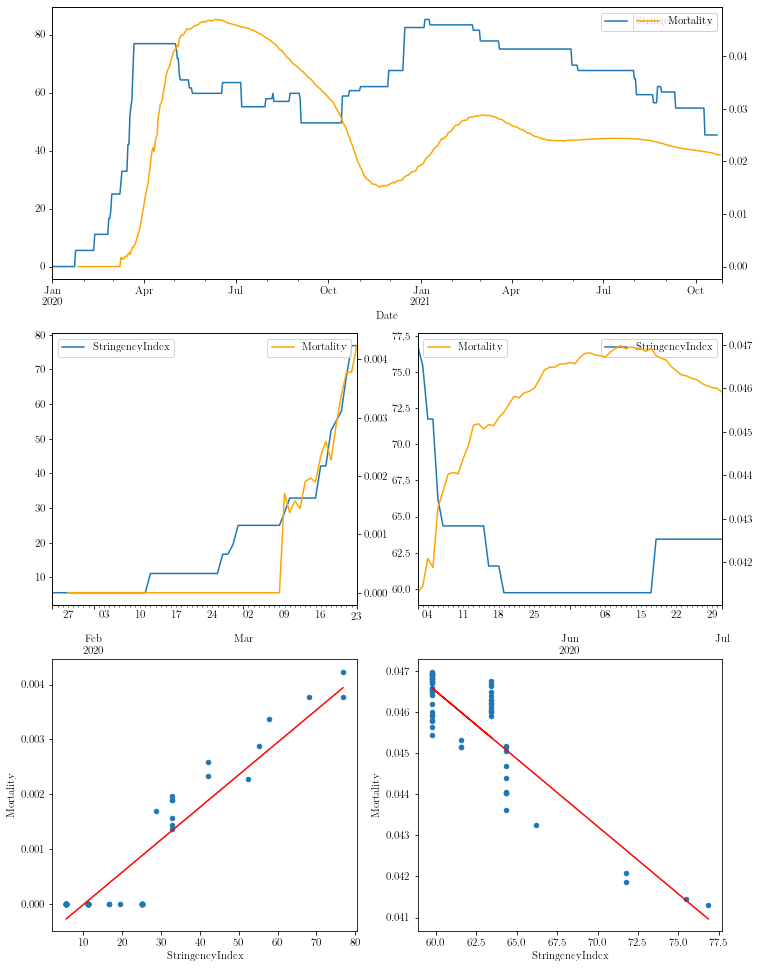

In [4]:
oneCountry_analysis('Germany', days_0=60, days_x=60, corr_matrix=False, mortality_shift=False, plot_figures = True)

### Functionality of plot_corr_coeff_lifted()

- give list of countries to the function
- run oneCountry_analysis() on each country individually for mortality_shift = True and mortality_shift = False
- extract correlation coefficients for time frames from oneCountry_analysis()
- plot the correlation coefficients in bar plots for each country and for mortality shifted and not for the time frames after the first peak

In [10]:
def plot_corr_coeff_lifted(list_countries, days_0=70, days_x=70, method='spearman', table=False, save=False):
    
    # INPUTS:
    # list_countries (list): list of countries that are compared
    # days_0 (int):          see oneCountry_Analysis()
    # days_x (int):          see oneCountry_Analysis() -> not important as only days_0 are used mainly
    # method (string):       see oneCountry_Analysis()
    # table (bool):          if true, creates DataFrame with the correlation coefficients summarized
    # save (bool):           if true, saves the bar plot created
    
    # OUTPUTS:
    # table (DataFrame): if table is true
    # 0 :                if table is false 
    
    len_list = len(list_countries)
    plot_list = np.arange(0, len_list, 1)

    corr_imp = []
    corr_lifted = []

    corr_imp_shift = []
    corr_lifted_shift = []

    for i in list_countries:
        _, _, temp_corr_i, temp_corr_l = oneCountry_analysis(i, days_0=days_0, days_x=days_x)
        _, _, temp_corr_i_shift, temp_corr_l_shift = oneCountry_analysis(i, days_0=days_0, days_x=days_x, mortality_shift=True)

        corr_imp.append(temp_corr_i)
        corr_lifted.append(temp_corr_l)

        corr_imp_shift.append(temp_corr_i_shift)
        corr_lifted_shift.append(temp_corr_l_shift)
        
    if table == True:
        Data_summary = pd.DataFrame({'Country': list_countries, 'Correlation_implemented': corr_imp, 'Correlation_implemented_mortality-shift': corr_imp_shift, 'Correlation_lifted': corr_lifted, 'Correlation_lifted_mortality-shift': corr_lifted_shift})

    # Width of boxes in bar plot
    width = 0.2
    
    # Colormap for extracting colors
    cmap = plt.cm.get_cmap('ocean')    
    
    # Define figure
    fig = plt.figure(figsize=(5.9, 3.4))
    rc('text', usetex=True)
    ax = fig.add_subplot(111)

    # plot hoizontal line at 0, 0.5 and -0.5
    ax.hlines(0, -1, len_list, color='grey', linewidth=0.15, zorder=1)
    ax.hlines(0.5, -1, len_list, color='grey', linewidth=0.15, zorder=1)
    ax.hlines(-0.5, -1, len_list, color='grey', linewidth=0.15, zorder=1)
    
    # Create bars for coefficients for 1st lifted periods 
    bar_corr_lifted = ax.bar(plot_list-width/2.-0.005, corr_lifted, width, color=cmap(0.1), label='Original', zorder=2)
    bar_cor_lifted_shift = ax.bar(plot_list + width/2. + 0.005, corr_lifted_shift, width, color=cmap(0.7), label='Shifted Mortality', zorder=2)
    
    # set x labels as country names
    ax.set_xticks(plot_list)
    ax.set_xticklabels(list_countries)
    ax.set_xlim(-0.5, len_list-0.5)

    # set y labels 
    ax.set_ylabel('Correlation coefficient')
    ax.set_ylim(-1, 1)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    
    # spines
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    
    ax.tick_params(color='grey', labelcolor='k')
    ax.yaxis.label.set_color('k')
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

    # define legend
    plt.legend(frameon=False)
    
    # save figure
    if save == True:
        save_name = 'figure_coeff_days-' + str(days_x) + '_' + method + '.png'
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    
    # plot figure
    plt.show()
    
    if table == True:
        return Data_summary
    else:
        return 0

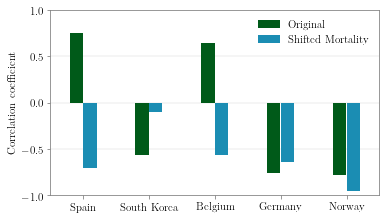

,Country,Correlation_implemented,Correlation_implemented_mortality-shift,Correlation_lifted,Correlation_lifted_mortality-shift
0,Spain,0.955052,0.813415,0.751659,-0.708051
1,South Korea,0.919345,0.687878,-0.567858,-0.098012
2,Belgium,0.930189,0.421968,0.639727,-0.566583
3,Germany,0.873734,0.401700,-0.763699,-0.640538
4,Norway,0.947028,0.345588,-0.782646,-0.961004


In [12]:
list_countries = ['Spain', 'South Korea', 'Belgium', 'Germany', 'Norway']

plot_corr_coeff_lifted(list_countries, days_x=50, table=True, save=False)